In [1]:
import pymysql
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
conn = pymysql.connect(
    host="127.0.0.1",
    user="root",
    password="password",
    database="olist"
)

In [3]:
repurchase_sales_sql = """
    WITH total_order AS (
    	SELECT
    		category_name_translation.product_category_name_english AS category_name,
    		orders.customer_id,
    		COUNT(orders.order_id) AS cnt_order
    	FROM
    		orders
    	INNER JOIN
    		order_items
    	ON
    		orders.order_id = order_items.order_id
    	INNER JOIN
    		products
    	ON
    		order_items.product_id = products.product_id
    	INNER JOIN
    		category_name_translation
    	ON
    		products.product_category_name = category_name_translation.product_category_name
        WHERE
            orders.order_status = 'delivered'
    	GROUP BY
    		category_name, customer_id
    ),
    category_repurchase AS (
    	SELECT
    		category_name,
    		(SUM(IF (cnt_order > 1, 1, 0)) / COUNT(cnt_order)) * 100 AS repurchase_rate
    	FROM
    		total_order
    	GROUP BY
    		category_name
    ),
    cnt_sales AS (
        SELECT
            category_name_translation.product_category_name_english AS category_name,
            COUNT(order_items.product_id) AS count_sales
        FROM
            order_items
    	INNER JOIN
    		products
    	ON
    		order_items.product_id = products.product_id
    	INNER JOIN
    		orders
    	ON
    		order_items.order_id = orders.order_id
    	INNER JOIN
    		category_name_translation
    	ON
    		products.product_category_name = category_name_translation.product_category_name
        GROUP BY
            category_name
    )
    SELECT
    	category_repurchase.category_name,
        cnt_sales.count_sales,
    	category_repurchase.repurchase_rate
    FROM
    	category_repurchase
    INNER JOIN
    	cnt_sales
    ON
    	category_repurchase.category_name = cnt_sales.category_name
    ORDER BY
    	count_sales DESC;
"""

In [4]:
repurchase_sales_df = pd.read_sql(repurchase_sales_sql, conn)
repurchase_sales_df = repurchase_sales_df.set_index("category_name")
repurchase_sales_df.to_csv("repurchase_sales.csv", header=True)

C:\Users\minni\AppData\Local\Temp\ipykernel_41124\571704793.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  repurchase_sales_df = pd.read_sql(repurchase_sales_sql, conn)


In [5]:
repurchase_sales_df

,count_sales,repurchase_rate
category_name,,
bed_bath_table,11115,13.7295
health_beauty,9670,7.0198
sports_leisure,8641,9.2165
furniture_decor,8334,19.2802
computers_accessories,7827,11.2557
...,...,...
arts_and_craftmanship,24,4.3478
la_cuisine,14,7.6923
cds_dvds_musicals,14,16.6667


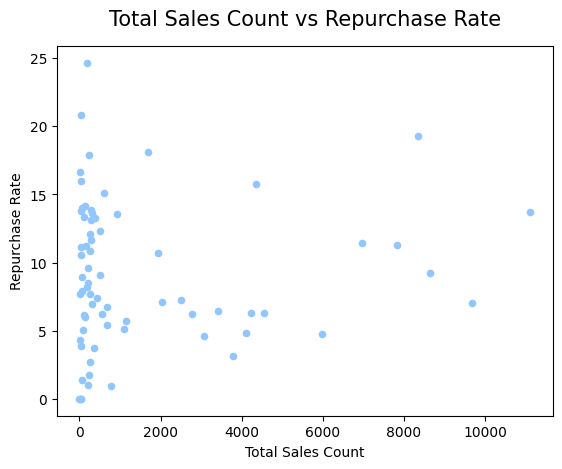

In [6]:
plt.style.use("seaborn-v0_8-pastel")
figure = repurchase_sales_df.plot(
    kind="scatter", 
    x="count_sales", 
    y="repurchase_rate"
)
figure.set_title("Total Sales Count vs Repurchase Rate", size=15, pad=15)
plt.xlabel("Total Sales Count")
plt.ylabel("Repurchase Rate")
plt.savefig("repurchase_sales.png", bbox_inches='tight')